# Modelling

In [43]:
import pandas as pd
import matplotlib.pyplot as plt

In [5]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from imblearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, accuracy_score, plot_roc_curve, roc_auc_score, recall_score, precision_score, f1_score

from imblearn.over_sampling import SMOTE

In [2]:
train_comb = pd.read_csv('../assets/train_comb.csv')

In [3]:
train_comb['date'] = pd.to_datetime(train_comb['date'])

In [4]:
train_comb.set_index('date', inplace=True)

In [6]:
# dropping trap column for now as it is not numeralize yet
X = train_comb.drop(columns=['wnvpresent', 'trap'])
y = train_comb['wnvpresent']

In [7]:
# train/test split on data
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)

In [8]:
# Scale X data
ss = StandardScaler()

In [9]:
Xs_train, Xs_val = ss.fit_transform(X_train), ss.transform(X_val)

## Baseline Score

In [10]:
train_comb['wnvpresent'].value_counts(normalize=True)

0    0.944966
1    0.055034
Name: wnvpresent, dtype: float64

The baseline accuracy score would be 0.948.

## Account for Imbalanced Class

We note from our target column: 'wnvpresent' that there is massive class imbalance. We can resolve this by using SMOTE and embed it within a pipeline.

In [11]:
# sm = SMOTE()

In [12]:
# Xsm_train, ysm_train = sm.fit_resample(Xs_train, y_train)

## Logistic Regression

In [13]:
# instantiate pipeline
pipe = Pipeline([('sampling', SMOTE()),
                 ('logreg', LogisticRegression(solver='liblinear', random_state=100))
                ])

In [14]:
pipe.get_params()

{'memory': None,
 'steps': [('sampling', SMOTE()),
  ('logreg', LogisticRegression(random_state=100, solver='liblinear'))],
 'verbose': False,
 'sampling': SMOTE(),
 'logreg': LogisticRegression(random_state=100, solver='liblinear'),
 'sampling__k_neighbors': 5,
 'sampling__n_jobs': None,
 'sampling__random_state': None,
 'sampling__sampling_strategy': 'auto',
 'logreg__C': 1.0,
 'logreg__class_weight': None,
 'logreg__dual': False,
 'logreg__fit_intercept': True,
 'logreg__intercept_scaling': 1,
 'logreg__l1_ratio': None,
 'logreg__max_iter': 100,
 'logreg__multi_class': 'auto',
 'logreg__n_jobs': None,
 'logreg__penalty': 'l2',
 'logreg__random_state': 100,
 'logreg__solver': 'liblinear',
 'logreg__tol': 0.0001,
 'logreg__verbose': 0,
 'logreg__warm_start': False}

In [15]:
# set params to gridsearch
# sampling params set to comment because it was taking too long to fit
logreg_params = {
    'logreg__penalty': ['l1','l2'],
    'logreg__C': [0.5, 1, 1.5, 2],
    #'sampling__sampling_strategy': ['minority', 'not minority', 'auto'],
    #'sampling__k_neighbors': [3, 5],
}

In [16]:
logreg_grid = GridSearchCV(pipe, logreg_params, verbose=2, n_jobs=-1)

In [17]:
%%time
logreg_grid.fit(Xs_train, y_train)

Fitting 5 folds for each of 8 candidates, totalling 40 fits
Wall time: 2min 28s


GridSearchCV(estimator=Pipeline(steps=[('sampling', SMOTE()),
                                       ('logreg',
                                        LogisticRegression(random_state=100,
                                                           solver='liblinear'))]),
             n_jobs=-1,
             param_grid={'logreg__C': [0.5, 1, 1.5, 2],
                         'logreg__penalty': ['l1', 'l2']},
             verbose=2)

In [18]:
logreg_grid.best_score_

0.7508823095406706

In [19]:
logreg_grid.best_params_

{'logreg__C': 1.5, 'logreg__penalty': 'l1'}

In [20]:
y_val_pred = logreg_grid.predict(Xs_val)

In [21]:
y_val_pred_proba = logreg_grid.predict_proba(Xs_val)[:, 1]

In [22]:
# create a dictionary to hold the results
scores = {'classifier': 'Logistic Regression'}

In [23]:
scores['accuracy'] = accuracy_score(y_val, y_val_pred)
scores['recall'] = recall_score(y_val, y_val_pred)
scores['precision'] = precision_score(y_val, y_val_pred)
scores['f1_score'] = f1_score(y_val, y_val_pred)
scores['val_roc_auc_score'] = roc_auc_score(y_val, y_val_pred_proba)

In [24]:
# create a list to hold the dict
logreg_results = []
logreg_results.append(scores)

In [25]:
# create a df to hold all our classifier performance
df_results = pd.DataFrame(logreg_results)
df_results

,classifier,accuracy,recall,precision,f1_score,val_roc_auc_score
0,Logistic Regression,0.753131,0.780702,0.15438,0.257784,0.850046


In [26]:
logreg_grid.score(Xs_val, y_val)

0.753131021194605

In [ ]:
# ROC curve
plot_roc_curve(logreg_grid, Xs_val, y_val)

# add worst case scenario line
plt.plot([0,1], [0,1], label='baseline', linestyle='--')

# add a legend
plt.legend()

In [28]:
confusion_matrix(y_val, y_val_pred)

array([[2949,  975],
       [  50,  178]], dtype=int64)

In [29]:
tn, fp, fn, tp = confusion_matrix(y_val, y_val_pred).ravel()

print("True Negatives: %s" % tn)
print("False Positives: %s" % fp)
print("False Negatives: %s" % fn)
print("True Positives: %s" % tp)

True Negatives: 2949
False Positives: 975
False Negatives: 50
True Positives: 178


## SVM

In [30]:
# instantiate pipeline
pipe = Pipeline([('sampling', SMOTE()),
                 ('svc', SVC(probability=True, random_state=100)) # probability=True is needed to calculate predict_proba but fitting grid model would take very long
                ])

In [31]:
pipe.get_params()

{'memory': None,
 'steps': [('sampling', SMOTE()),
  ('svc', SVC(probability=True, random_state=100))],
 'verbose': False,
 'sampling': SMOTE(),
 'svc': SVC(probability=True, random_state=100),
 'sampling__k_neighbors': 5,
 'sampling__n_jobs': None,
 'sampling__random_state': None,
 'sampling__sampling_strategy': 'auto',
 'svc__C': 1.0,
 'svc__break_ties': False,
 'svc__cache_size': 200,
 'svc__class_weight': None,
 'svc__coef0': 0.0,
 'svc__decision_function_shape': 'ovr',
 'svc__degree': 3,
 'svc__gamma': 'scale',
 'svc__kernel': 'rbf',
 'svc__max_iter': -1,
 'svc__probability': True,
 'svc__random_state': 100,
 'svc__shrinking': True,
 'svc__tol': 0.001,
 'svc__verbose': False}

In [32]:
svc_params = {
    'svc__C': [5, 7, 9],
    'svc__kernel': ['rbf'],  #'poly'
    #'sampling__sampling_strategy': ['minority', 'not minority', 'auto'],
    #'sampling__k_neighbors': [3, 5],      
}

In [33]:
svc_grid = GridSearchCV(pipe, svc_params, verbose=2, n_jobs=-1)

In [34]:
%%time
svc_grid.fit(Xs_train, y_train)

# wall time is cut by half we dont put SVC(probability=True) in the pipeline

Fitting 5 folds for each of 3 candidates, totalling 15 fits
Wall time: 8min 44s


GridSearchCV(estimator=Pipeline(steps=[('sampling', SMOTE()),
                                       ('svc',
                                        SVC(probability=True,
                                            random_state=100))]),
             n_jobs=-1,
             param_grid={'svc__C': [5, 7, 9], 'svc__kernel': ['rbf']},
             verbose=2)

In [35]:
svc_grid.best_score_

0.8492286517176119

In [36]:
svc_grid.best_params_

{'svc__C': 9, 'svc__kernel': 'rbf'}

In [37]:
y_val_pred = svc_grid.predict(Xs_val)

In [38]:
y_val_pred_proba = svc_grid.predict_proba(Xs_val)[:, 1]

In [39]:
# create a dictionary to hold the results
scores = {'classifier': 'SVM'}

scores['accuracy'] = accuracy_score(y_val, y_val_pred)
scores['recall'] = recall_score(y_val, y_val_pred)
scores['precision'] = precision_score(y_val, y_val_pred)
scores['f1_score'] = f1_score(y_val, y_val_pred)
scores['val_roc_auc_score'] = roc_auc_score(y_val, y_val_pred_proba)

In [40]:
# create list to hold the dict
svm_results = []
svm_results.append(scores)

In [41]:
# append dict to df to compare classifier performance

df_results = df_results.append(svm_results)
df_results

,classifier,accuracy,recall,precision,f1_score,val_roc_auc_score
0,Logistic Regression,0.753131,0.780702,0.154380,0.257784,0.850046
0,SVM,0.850193,0.583333,0.201515,0.299550,0.857957


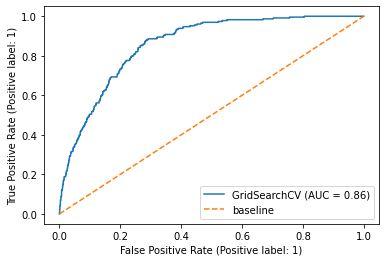

In [44]:
# ROC curve
plot_roc_curve(svc_grid, Xs_val, y_val)

# add worst case scenario line
plt.plot([0,1], [0,1], label='baseline', linestyle='--')

# add a legend
plt.legend()

In [45]:
confusion_matrix(y_val, y_val_pred)

array([[3397,  527],
       [  95,  133]], dtype=int64)

In [46]:
tn, fp, fn, tp = confusion_matrix(y_val, y_val_pred).ravel()

print("True Negatives: %s" % tn)
print("False Positives: %s" % fp)
print("False Negatives: %s" % fn)
print("True Positives: %s" % tp)

True Negatives: 3397
False Positives: 527
False Negatives: 95
True Positives: 133


## PCA

In [47]:
# instantiate pca
pca = PCA(random_state=100)

In [48]:
pca.fit(Xs_train)

PCA(random_state=100)

In [49]:
Z_train, Z_val = pca.transform(Xs_train), pca.transform(Xs_val)

In [50]:
pca.explained_variance_ratio_.round(3)

array([0.241, 0.141, 0.091, 0.067, 0.048, 0.043, 0.04 , 0.036, 0.033,
       0.033, 0.031, 0.029, 0.027, 0.023, 0.022, 0.021, 0.018, 0.017,
       0.013, 0.01 , 0.007, 0.003, 0.003, 0.002, 0.001, 0.   , 0.   ,
       0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
       0.   , 0.   ])

In [51]:
pca.explained_variance_ratio_.round(3)[:10].sum()

0.7730000000000001

We see that the first 10 components explain 77% of the variance.

In [52]:
pca.explained_variance_ratio_.round(3)[:25].sum()

1.0

The first 25 component explain 100% of the variance.

### Logistic Regression with PCA

In [53]:
# embed pca in a pipeline
pipe = Pipeline([('sampling', SMOTE()),
                 ('pca', PCA(n_components=[20, 25, 30])),
                 ('logreg', LogisticRegression(solver='liblinear', random_state=100))
                ])

In [54]:
pipe.get_params()

{'memory': None,
 'steps': [('sampling', SMOTE()),
  ('pca', PCA(n_components=[20, 25, 30])),
  ('logreg', LogisticRegression(random_state=100, solver='liblinear'))],
 'verbose': False,
 'sampling': SMOTE(),
 'pca': PCA(n_components=[20, 25, 30]),
 'logreg': LogisticRegression(random_state=100, solver='liblinear'),
 'sampling__k_neighbors': 5,
 'sampling__n_jobs': None,
 'sampling__random_state': None,
 'sampling__sampling_strategy': 'auto',
 'pca__copy': True,
 'pca__iterated_power': 'auto',
 'pca__n_components': [20, 25, 30],
 'pca__random_state': None,
 'pca__svd_solver': 'auto',
 'pca__tol': 0.0,
 'pca__whiten': False,
 'logreg__C': 1.0,
 'logreg__class_weight': None,
 'logreg__dual': False,
 'logreg__fit_intercept': True,
 'logreg__intercept_scaling': 1,
 'logreg__l1_ratio': None,
 'logreg__max_iter': 100,
 'logreg__multi_class': 'auto',
 'logreg__n_jobs': None,
 'logreg__penalty': 'l2',
 'logreg__random_state': 100,
 'logreg__solver': 'liblinear',
 'logreg__tol': 0.0001,
 'logreg

In [55]:
logreg_pca_params = {
    'logreg__penalty': ['l1','l2'],
    'logreg__C': [1, 1.5, 2],
    'pca__n_components': [20, 30, 40]
    #'sampling__sampling_strategy': ['minority', 'not minority', 'auto'],
    #'sampling__k_neighbors': [3, 5],
}

In [56]:
logreg_pca_grid = GridSearchCV(pipe, logreg_pca_params, verbose=2, n_jobs=-1)

In [57]:
%%time
logreg_pca_grid.fit(Xs_train, y_train)

Fitting 5 folds for each of 18 candidates, totalling 90 fits


C:\Users\caspe\anaconda3\envs\firstday\lib\site-packages\sklearn\model_selection\_search.py:918: UserWarning: One or more of the test scores are non-finite: [0.74839409 0.75007929        nan 0.74999984 0.74863447        nan
 0.74775152 0.74999913        nan 0.74999952 0.75048103        nan
 0.74726991 0.75056106        nan 0.74751059 0.74887534        nan]
  warnings.warn(


Wall time: 9.83 s


GridSearchCV(estimator=Pipeline(steps=[('sampling', SMOTE()),
                                       ('pca', PCA(n_components=[20, 25, 30])),
                                       ('logreg',
                                        LogisticRegression(random_state=100,
                                                           solver='liblinear'))]),
             n_jobs=-1,
             param_grid={'logreg__C': [1, 1.5, 2],
                         'logreg__penalty': ['l1', 'l2'],
                         'pca__n_components': [20, 30, 40]},
             verbose=2)

In [58]:
logreg_pca_grid.best_score_

0.7505610567223385

In [59]:
logreg_pca_grid.best_params_

{'logreg__C': 2, 'logreg__penalty': 'l1', 'pca__n_components': 30}

In [60]:
y_val_pred = logreg_pca_grid.predict(Xs_val)

In [61]:
y_val_pred_proba = logreg_pca_grid.predict_proba(Xs_val)[:, 1]

In [62]:
# create a dictionary to hold the results
scores = {'classifier': 'Logistic Regression with PCA'}

scores['accuracy'] = accuracy_score(y_val, y_val_pred)
scores['recall'] = recall_score(y_val, y_val_pred)
scores['precision'] = precision_score(y_val, y_val_pred)
scores['f1_score'] = f1_score(y_val, y_val_pred)
scores['val_roc_auc_score'] = roc_auc_score(y_val, y_val_pred_proba)

In [63]:
# create list to hold the dict
logreg_pca_results = []
logreg_pca_results.append(scores)

In [64]:
# append dict to df to compare classifier performance
df_results = df_results.append(logreg_pca_results)
df_results

,classifier,accuracy,recall,precision,f1_score,val_roc_auc_score
0,Logistic Regression,0.753131,0.780702,0.154380,0.257784,0.850046
0,SVM,0.850193,0.583333,0.201515,0.299550,0.857957
0,Logistic Regression with PCA,0.750482,0.785088,0.153516,0.256815,0.849525


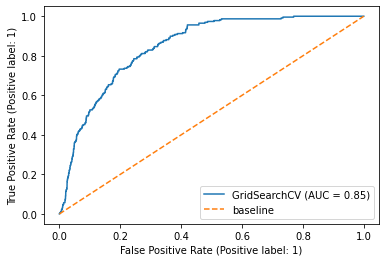

In [65]:
# ROC curve
plot_roc_curve(logreg_pca_grid, Xs_val, y_val)

# add worst case scenario line
plt.plot([0,1], [0,1], label='baseline', linestyle='--')

# add a legend
plt.legend()

In [66]:
confusion_matrix(y_val, y_val_pred)

array([[2937,  987],
       [  49,  179]], dtype=int64)

In [67]:
tn, fp, fn, tp = confusion_matrix(y_val, y_val_pred).ravel()

print("True Negatives: %s" % tn)
print("False Positives: %s" % fp)
print("False Negatives: %s" % fn)
print("True Positives: %s" % tp)

True Negatives: 2937
False Positives: 987
False Negatives: 49
True Positives: 179


### SVM with PCA

In [68]:
pipe = Pipeline([('sampling', SMOTE()),
                 ('pca', PCA(n_components=[20, 30, 40])),
                 ('svc', SVC(probability=True, random_state=100))
])

In [69]:
pipe.get_params()

{'memory': None,
 'steps': [('sampling', SMOTE()),
  ('pca', PCA(n_components=[20, 30, 40])),
  ('svc', SVC(probability=True, random_state=100))],
 'verbose': False,
 'sampling': SMOTE(),
 'pca': PCA(n_components=[20, 30, 40]),
 'svc': SVC(probability=True, random_state=100),
 'sampling__k_neighbors': 5,
 'sampling__n_jobs': None,
 'sampling__random_state': None,
 'sampling__sampling_strategy': 'auto',
 'pca__copy': True,
 'pca__iterated_power': 'auto',
 'pca__n_components': [20, 30, 40],
 'pca__random_state': None,
 'pca__svd_solver': 'auto',
 'pca__tol': 0.0,
 'pca__whiten': False,
 'svc__C': 1.0,
 'svc__break_ties': False,
 'svc__cache_size': 200,
 'svc__class_weight': None,
 'svc__coef0': 0.0,
 'svc__decision_function_shape': 'ovr',
 'svc__degree': 3,
 'svc__gamma': 'scale',
 'svc__kernel': 'rbf',
 'svc__max_iter': -1,
 'svc__probability': True,
 'svc__random_state': 100,
 'svc__shrinking': True,
 'svc__tol': 0.001,
 'svc__verbose': False}

In [70]:
svc_pca_params = {
    'svc__C': [5, 7, 9],
    'svc__kernel': ['rbf'],  # 'poly'
    'pca__n_components': [20, 30, 40]
    #'sampling__sampling_strategy': ['minority', 'not minority', 'auto'],
    #'sampling__k_neighbors': [3, 5],      
}

In [71]:
svc_pca_grid = GridSearchCV(pipe, svc_pca_params, verbose=2, n_jobs=-1)

In [72]:
%%time
svc_pca_grid.fit(Xs_train, y_train)

## lol example of time taken (14 mins) if we put SVC(probability=True) in the pipeline

Fitting 5 folds for each of 9 candidates, totalling 45 fits


C:\Users\caspe\anaconda3\envs\firstday\lib\site-packages\sklearn\model_selection\_search.py:918: UserWarning: One or more of the test scores are non-finite: [0.84328749 0.84714139 0.84987113 0.84441192 0.8485064  0.85051353
        nan        nan        nan]
  warnings.warn(


Wall time: 14min 47s


GridSearchCV(estimator=Pipeline(steps=[('sampling', SMOTE()),
                                       ('pca', PCA(n_components=[20, 30, 40])),
                                       ('svc',
                                        SVC(probability=True,
                                            random_state=100))]),
             n_jobs=-1,
             param_grid={'pca__n_components': [20, 30, 40], 'svc__C': [5, 7, 9],
                         'svc__kernel': ['rbf']},
             verbose=2)

In [73]:
svc_pca_grid.best_score_

0.8505135341160763

In [74]:
svc_pca_grid.best_params_

{'pca__n_components': 30, 'svc__C': 9, 'svc__kernel': 'rbf'}

In [75]:
y_val_pred = svc_pca_grid.predict(Xs_val)

In [76]:
y_val_pred_proba = svc_pca_grid.predict_proba(Xs_val)[:, 1]

In [77]:
# create a dictionary to hold the results
scores = {'classifier': 'SVM with PCA'}

scores['accuracy'] = accuracy_score(y_val, y_val_pred)
scores['recall'] = recall_score(y_val, y_val_pred)
scores['precision'] = precision_score(y_val, y_val_pred)
scores['f1_score'] = f1_score(y_val, y_val_pred)
scores['val_roc_auc_score'] = roc_auc_score(y_val, y_val_pred_proba)

In [78]:
# create list to hold the dict
svc_pca_results = []
svc_pca_results.append(scores)

In [79]:
# append dict to df to compare classifier performance
df_results = df_results.append(svc_pca_results)

In [80]:
df_results.reset_index(drop=True)

,classifier,accuracy,recall,precision,f1_score,val_roc_auc_score
0,Logistic Regression,0.753131,0.780702,0.154380,0.257784,0.850046
1,SVM,0.850193,0.583333,0.201515,0.299550,0.857957
2,Logistic Regression with PCA,0.750482,0.785088,0.153516,0.256815,0.849525
3,SVM with PCA,0.850674,0.596491,0.204819,0.304933,0.859579


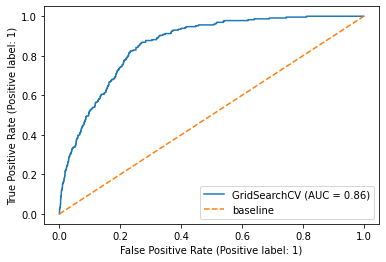

In [81]:
# ROC curve
plot_roc_curve(svc_pca_grid, Xs_val, y_val)

# add worst case scenario line
plt.plot([0,1], [0,1], label='baseline', linestyle='--')

# add a legend
plt.legend()

In [82]:
confusion_matrix(y_val, y_val_pred)

array([[3396,  528],
       [  92,  136]], dtype=int64)

In [83]:
tn, fp, fn, tp = confusion_matrix(y_val, y_val_pred).ravel()

print("True Negatives: %s" % tn)
print("False Positives: %s" % fp)
print("False Negatives: %s" % fn)
print("True Positives: %s" % tp)

True Negatives: 3396
False Positives: 528
False Negatives: 92
True Positives: 136


# Feature Importance

In [84]:
# note: svm on rbf has no feature importance, only svm on linear has it
# https://stackoverflow.com/questions/41592661/determining-the-most-contributing-features-for-svm-classifier-in-sklearn

In [85]:
# instead we will look at feature importance for logreg pca

# how to pull feature names for pca?

# logreg_pca_features = pd.DataFrame({'feature_names': X_train.columns,
#                                    'feature_importance': logreg_pca_grid.best_estimator_[2].coef_[0]})

# error code because feature_names has 38 values, feature_importance has 30 values since svc_pca_grid has 30 components

Feature Importance based on Logistic Regression

In [86]:
logreg_grid.best_estimator_[1].coef_

array([[ 2.02363154e-01,  3.18995274e+00,  1.30208612e+01,
         4.93158877e-01,  8.84038689e-01, -5.49448114e-01,
         2.06588187e-01,  0.00000000e+00, -5.49352358e-02,
        -1.04352642e-01, -5.16200541e-01,  4.65100216e-01,
         1.01345498e+00, -1.63170903e-01, -5.01408479e-02,
         1.93318215e+00, -2.14021666e+00, -1.27623698e-01,
        -8.27818217e-02,  5.96072701e-02,  0.00000000e+00,
         9.80958570e-02, -8.51877177e-02, -4.84648060e-02,
         0.00000000e+00,  0.00000000e+00,  7.38445008e-02,
         0.00000000e+00, -1.55512090e-02,  0.00000000e+00,
         0.00000000e+00,  3.54400075e-01,  0.00000000e+00,
         5.42139447e-03,  1.07072428e+01, -2.58312630e-01,
        -5.61332569e-02,  1.04243008e-01]])

In [87]:
logreg_features = pd.DataFrame({'feature_names': X_train.columns,
                                'feature_importance': logreg_grid.best_estimator_[1].coef_[0]})

# top 20 features
logreg_features.sort_values(by='feature_importance', ascending=False).head(20)

,feature_names,feature_importance
2,month,13.020861
34,total_sunlight_mins,10.707243
1,day,3.189953
15,stnpressure,1.933182
12,sunrise,1.013455
4,nummosquitos,0.884039
3,year,0.493159
11,wetbulb,0.465100
31,ts,0.354400
6,tmax,0.206588


# Cost Benefit Analysis

# Conclusion